<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/CERN_UE_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pion testing

Importing pion sample data for training and testing. Refer to `[Feature_Densities]_CERN_uncertainties.ipynb` for implementation.

In [ ]:
dir = 'drive/MyDrive/Colab Notebooks/pion_predictions/'

pion_predictions_train = np.load(dir + 'pion_predictions_train.npy')
pion_predictions_test = np.load(dir + 'pion_predictions_test.npy')

print('Training data shape:', pion_predictions_train.shape)
print('Test data shape:', pion_predictions_test.shape)

Training data shape: (947947, 128)
Test data shape: (524521, 128)


# Toy example

1. Generate a $\mathcal{N}(0,1)$ distribution.
2. Estimate its density through KDE.
3. Compute the likelihood of several points as their evaluation in the KDE.

**Expected result:** The likelihoods decrease as the evaluation points grow further apart from 0.

Likelihood of 0 in KDE: 99.84%
Likelihood of 1 in KDE: 66.66%
Likelihood of 2 in KDE: 14.27%
Likelihood of 3 in KDE: 1.49%


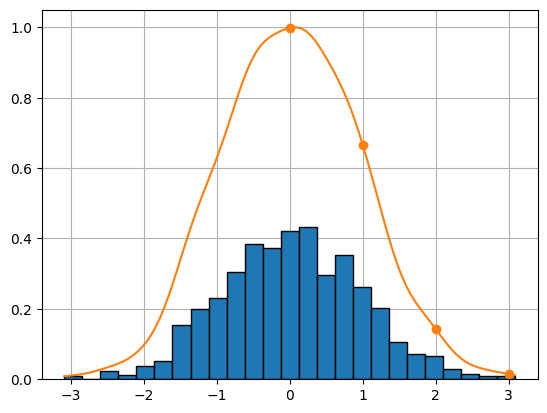

In [ ]:
def likelihood(kde, kde_max, value):
  return kde(value) / kde_max

data = np.random.normal(0, 1, 1000)
kde = gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
kde_x = kde(x)
kde_max = kde_x.max()

points = 0, 1, 2, 3
likelihoods = likelihood(kde, kde_max, points)

for point, like in zip(points, likelihoods):
  print(f'Likelihood of {point} in KDE: {round(100 * like, 2)}%')

plt.gca().set_axisbelow(True)
plt.grid()
plt.hist(data, 25, density=True, edgecolor='black')
plt.plot(x, likelihood(kde, kde_max, x))
plt.scatter(points, likelihoods, color='tab:orange')
plt.show()

# Results

In [ ]:
def plot_hist_kde(ax, d, data, kde):
  x = np.linspace(data.min(), data.max(), 100)
  ax.set_title(f'Dimension {d + 1}')
  ax.hist(data, 25, density=True)
  ax.plot(x, kde(x))

def estimate_likelihoods(train_data, test_data, eps=.01, n_samples=None, n_features=None, plot_shape=None):
  if not n_samples:
    n_samples = test_data.shape[0] # 524521 observations

  if not n_features:
    n_features = train_data.shape[1] # 128 dimensions

  if plot_shape:
    n_subplots = plot_shape[0] * plot_shape[1]

    if n_features != n_subplots:
      raise ValueError(f'Cannot plot {n_features} features in {n_subplots} subplots.')

    rows, columns = plot_shape
    fig, axes = plt.subplots(rows, columns, figsize=(2 * columns, 2 * rows))

  likelihoods = np.zeros((n_samples, n_features))

  for j in range(n_features):
    train_sample = train_data[:10000, j]
    kde = gaussian_kde(train_sample)

    for i in range(n_samples):
      point = test_data[i, j]
      likelihoods[i, j] = kde.integrate_box_1d(point - eps, point + eps)

    if plot_shape:
      plot_hist_kde(axes.flat[j], j, train_sample, kde)

  if plot_shape:
    plt.tight_layout()
    plt.show()

  return likelihoods

likelihoods = estimate_likelihoods(pion_predictions_train, pion_predictions_test, n_samples=128)

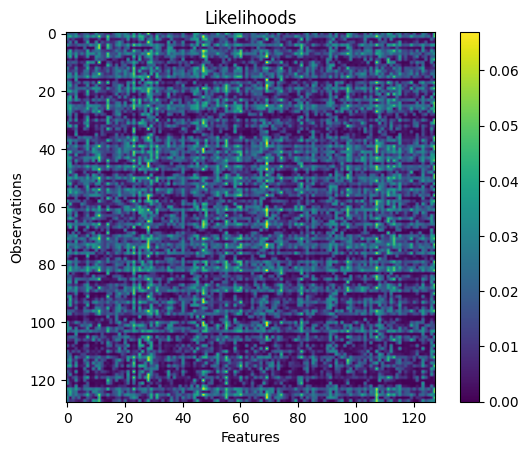

In [ ]:
def plot_likelihoods(likelihoods):
  plt.title('Likelihoods')
  plt.imshow(likelihoods)
  plt.xlabel('Features')
  plt.ylabel('Observations')
  plt.colorbar()
  plt.show()

plot_likelihoods(likelihoods)

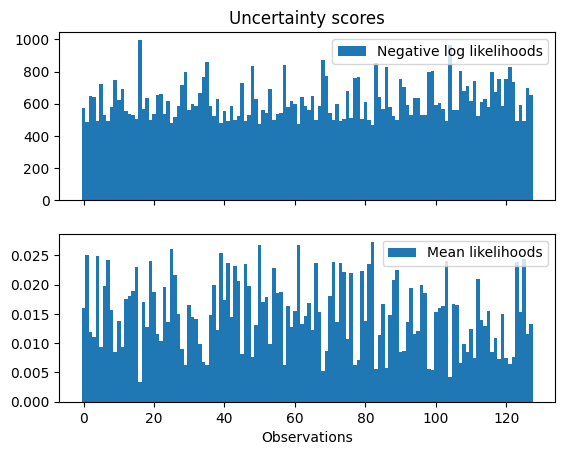

In [ ]:
def mean_likelihood(likelihoods):
  return likelihoods.mean(1)

def log_likelihood(likelihoods):
  likelihoods = likelihoods.copy()
  likelihoods[likelihoods == 0] = .01
  return np.log(likelihoods).sum(1)

def plot_likelihoods(ax, x, likelihoods, label):
  ax.bar(x, likelihoods, 1, label=label)
  ax.legend()

def plot_ue(likelihoods):
  log_likelihoods = log_likelihood(likelihoods)
  mean_likelihoods = mean_likelihood(likelihoods)

  fig, axes = plt.subplots(2, 1, sharex=True)
  x = range(likelihoods.shape[0])

  axes[0].set_title('Uncertainty scores')
  plot_likelihoods(axes[0], x, -log_likelihoods, 'Negative log likelihoods')
  plot_likelihoods(axes[1], x, mean_likelihoods, 'Mean likelihoods')
  axes[1].set_xlabel('Observations')
  plt.show()

plot_ue(likelihoods)

# Pion testing

In [56]:
dll_columns = 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt'

dir = 'drive/MyDrive/Colab Notebooks/outputs/pion/'

train_feats = np.load(dir + 'train_feats.npy')
train_targets = np.load(dir + 'train_targets.npy')
test_feats = np.load(dir + 'test_feats.npy')
test_targets = np.load(dir + 'test_targets.npy')

train_embeddings = np.load(dir + 'train_embeddings.npy')
train_predictions = np.load(dir + 'train_predictions.npy')
test_embeddings = np.load(dir + 'test_embeddings.npy')
test_predictions = np.load(dir + 'test_predictions.npy')

print('Train feats shape:', train_feats.shape)
print('Train targets shape:', train_targets.shape)
print('Test feats shape:', test_feats.shape)
print('Test targets shape:', test_targets.shape)

print('Train embeddings shape:', train_embeddings.shape)
print('Train predictions shape:', train_predictions.shape)
print('Test embeddings shape:', test_embeddings.shape)
print('Test predictions shape:', test_predictions.shape)

feats = np.concatenate((train_feats, test_feats))
targets = np.concatenate((train_targets, test_targets))
predictions = np.concatenate((train_predictions, test_predictions))

Train feats shape: (100000, 3)
Train targets shape: (100000, 5)
Test feats shape: (100000, 3)
Test targets shape: (100000, 5)
Train embeddings shape: (100000, 128)
Train predictions shape: (100000, 5)
Test embeddings shape: (100000, 128)
Test predictions shape: (100000, 5)


# Likelihood generation / loading

In [ ]:
from scipy.stats import gaussian_kde

Generating likelihoods through integration.

In [ ]:
n_samples, n_features = 10000, test_embeddings.shape[1]
integral_likelihoods = np.zeros((n_samples, n_features))
eps = .01

for j in range(n_features):
  train_sample = train_embeddings[:10000, j]
  kde = gaussian_kde(train_sample)

  for i in range(n_samples):
    point = test_embeddings[i, j]
    integral_likelihoods[i, j] = kde.integrate_box_1d(point - eps, point + eps)

np.save(dir + 'integral_likelihoods.npy', integral_likelihoods)

Generating likelihoods through range mapping.

In [70]:
n_samples, n_features = train_embeddings.shape

train_likelihoods = np.zeros((n_samples, n_features))
test_likelihoods = np.zeros((n_samples, n_features))

for j in range(n_features):
  print(f'Computing likelihood for feature {j}...')

  train_sample = train_embeddings[:1000, j]
  kde = gaussian_kde(train_sample)

  x = np.linspace(train_sample.min(), train_sample.max(), 10000)
  kde_max = kde(x).max()

  train_likelihoods[:, j] = kde(train_embeddings[:, j]) / kde_max
  test_likelihoods[:, j] = kde(test_embeddings[:, j]) / kde_max

np.save(dir + 'train_likelihoods.npy', train_likelihoods)
np.save(dir + 'test_likelihoods.npy', test_likelihoods)

Computing likelihood for feature 0...
Computing likelihood for feature 1...
Computing likelihood for feature 2...
Computing likelihood for feature 3...
Computing likelihood for feature 4...
Computing likelihood for feature 5...
Computing likelihood for feature 6...
Computing likelihood for feature 7...
Computing likelihood for feature 8...
Computing likelihood for feature 9...
Computing likelihood for feature 10...
Computing likelihood for feature 11...
Computing likelihood for feature 12...
Computing likelihood for feature 13...
Computing likelihood for feature 14...
Computing likelihood for feature 15...
Computing likelihood for feature 16...
Computing likelihood for feature 17...
Computing likelihood for feature 18...
Computing likelihood for feature 19...
Computing likelihood for feature 20...
Computing likelihood for feature 21...
Computing likelihood for feature 22...
Computing likelihood for feature 23...
Computing likelihood for feature 24...
Computing likelihood for feature 25

Load likelihoods from disk if the runtime environment has been disconnected.

In [ ]:
integral_likelihoods = np.load(dir + 'integral_likelihoods.npy')

mean_integral_likelihoods = integral_likelihoods.mean(1)

In [71]:
train_likelihoods = np.load(dir + 'train_likelihoods.npy')
test_likelihoods = np.load(dir + 'test_likelihoods.npy')

mean_train_likelihoods = train_likelihoods.mean(1)
mean_test_likelihoods = test_likelihoods.mean(1)

mean_likelihoods = np.concatenate((mean_train_likelihoods, mean_test_likelihoods))

In [72]:
train_likelihoods.shape, test_likelihoods.shape, mean_likelihoods.shape

((100000, 128), (100000, 128), (200000,))

# Correlation plotting

Plot correlation for all samples.

Correlation coefficient for RichDLLe: 0.0%
Correlation coefficient for RichDLLk: 55.3%
Correlation coefficient for RichDLLmu: 0.0%
Correlation coefficient for RichDLLp: 36.93%
Correlation coefficient for RichDLLbt: -59.65%


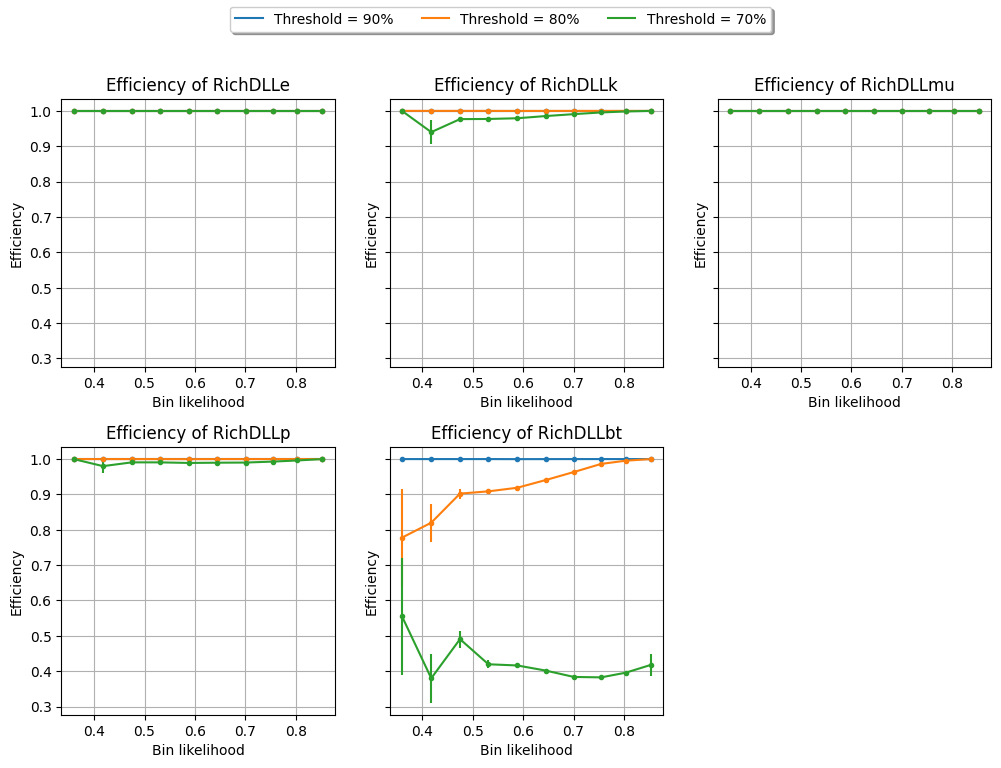

In [59]:
from scipy.stats import linregress

def select_threshold(feature, n_tracks_fraction=0.9):
    return np.quantile(feature, 1 - n_tracks_fraction)

def efficiency_bins(targets, threshold, idx):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiency = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, idx])
        err = compute_error(target[:, idx])

        efficiency.append(eff)
        errors.append(err)

    return efficiency, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)

  indices[indices == 0] = 1
  indices[indices == n_bins + 1] = n_bins

  return indices

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace = .3)

n_bins = 10

indices = compute_bin_indices(mean_test_likelihoods, n_bins)

bins_targets = [test_predictions[indices == i] for i in range(1, n_bins + 1)]
bins_likelihoods = [mean_test_likelihoods[indices == i].mean() for i in range(1, n_bins + 1)]

for idx, ax in zip(range(5), axes.flatten()):
    for fraction in .9, .8, .7:
        threshold = select_threshold(train_targets[:, idx], fraction)

        eff, err = efficiency_bins(bins_targets, threshold, idx)
        plot = ax.plot(bins_likelihoods, eff, label=f'Threshold = {int(fraction * 100)}%')
        ax.errorbar(bins_likelihoods, eff, err, fmt='.', color=plot[0].get_color())

    regress = linregress(bins_likelihoods, eff)
    print(f'Correlation coefficient for {dll_columns[idx]}: {round(regress.rvalue * 100, 2)}%')

    ax.set_title (f"Efficiency of {dll_columns[idx]}")
    ax.set_xlabel("Bin likelihood")
    ax.set_ylabel("Efficiency")
    ax.grid()

axes[-1, -1].axis(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=3)

plt.show()

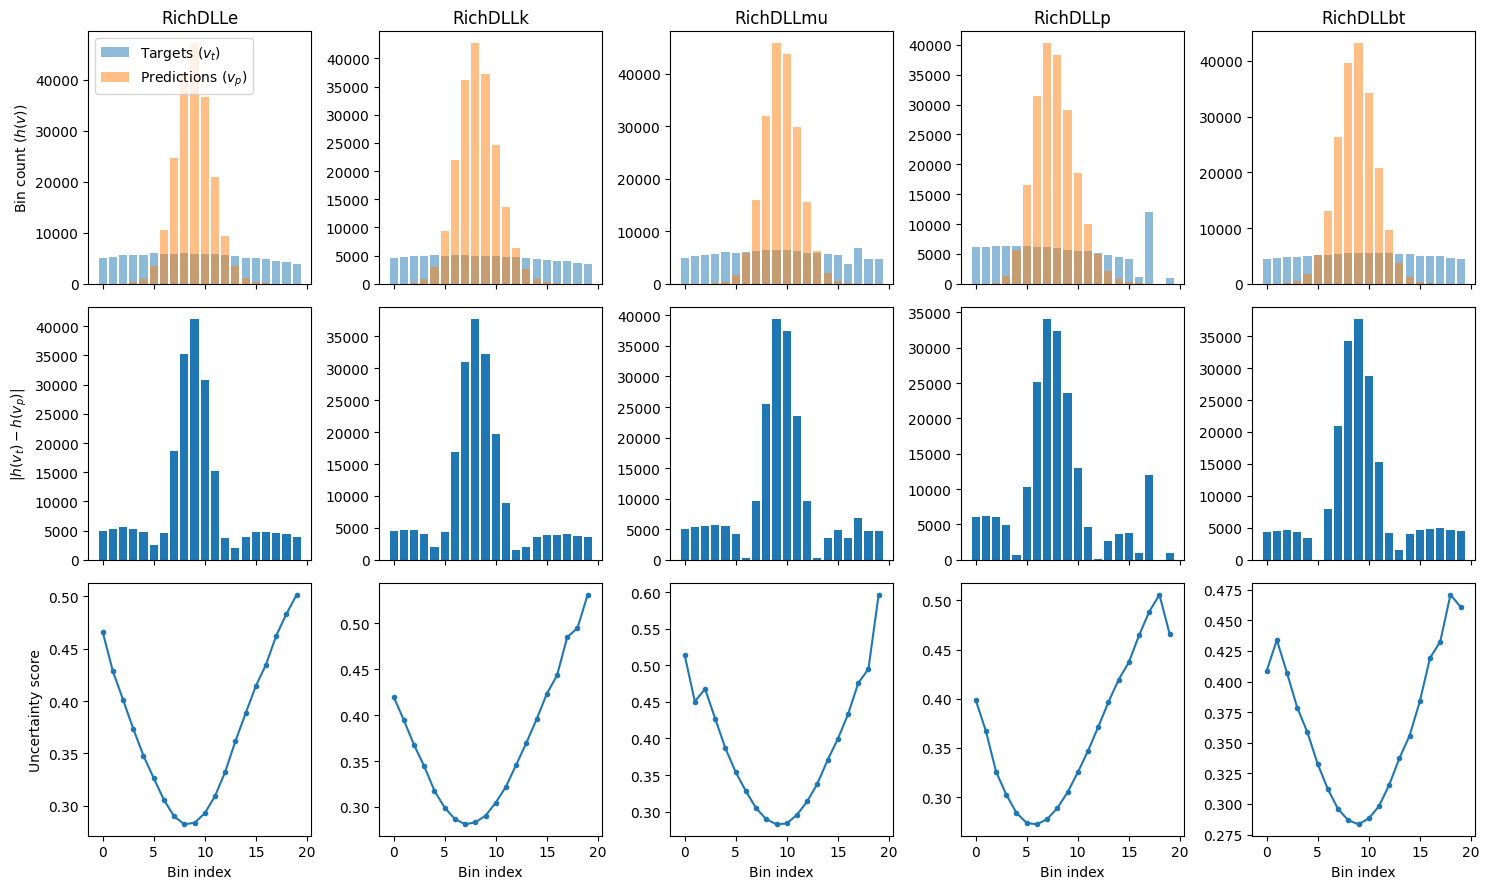

In [73]:
n_bins = 20
x = range(n_bins)

fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True)

for i in range(5):
  particle_targets = targets[:, i]
  particle_predictions = predictions[:, i]

  bin_edges = np.linspace(particle_predictions.min(), particle_predictions.max(), n_bins + 1)

  bin_indices = np.digitize(particle_targets, bin_edges)
  targets_per_bin = [particle_targets[bin_indices == i] for i in range(1, n_bins + 1)]

  bin_indices = np.digitize(particle_predictions, bin_edges)
  predictions_per_bin = [particle_predictions[bin_indices == i] for i in range(1, n_bins + 1)]

  n_targets_per_bin = np.array([bin.size for bin in targets_per_bin])
  n_predictions_per_bin = np.array([bin.size for bin in predictions_per_bin])

  likelihoods_per_bin = [1 - mean_likelihoods[bin_indices == i].mean() for i in range(1, n_bins + 1)]

  axes[0, i].set_title(dll_columns[i])

  axes[0, i].bar(x, n_targets_per_bin, alpha=.5, label='Targets ($v_t$)')
  axes[0, i].bar(x, n_predictions_per_bin, alpha=.5, label='Predictions ($v_p$)')

  axes[1, i].bar(x, abs(n_targets_per_bin - n_predictions_per_bin))

  axes[2, i].plot(x, likelihoods_per_bin, '.-')
  axes[2, i].set_xlabel('Bin index')

axes[0, 0].legend(loc='upper left')
axes[0, 0].set_ylabel('Bin count ($h(v)$)')
axes[1, 0].set_ylabel('$|h(v_t)-h(v_p)|$')
axes[2, 0].set_ylabel('Uncertainty score')
plt.tight_layout()
plt.show()

KL div: 1.5884042771201392
KL div: 1.356002279133075
KL div: 1.1351109956801784
KL div: 0.8064449805352335
KL div: 1.04894403443682
KL div: 0.5692974342153234
KL div: 0.6090944349744613
KL div: 0.6481038420946379
KL div: 1.0145432462831563
KL div: 0.8491860109962491
KL div: 1.0722590041934368
KL div: 1.0190654406102613
KL div: 1.203702855113963
KL div: 1.3559590463483278
KL div: 1.0986122330448356
KL div: 0.693147266382059


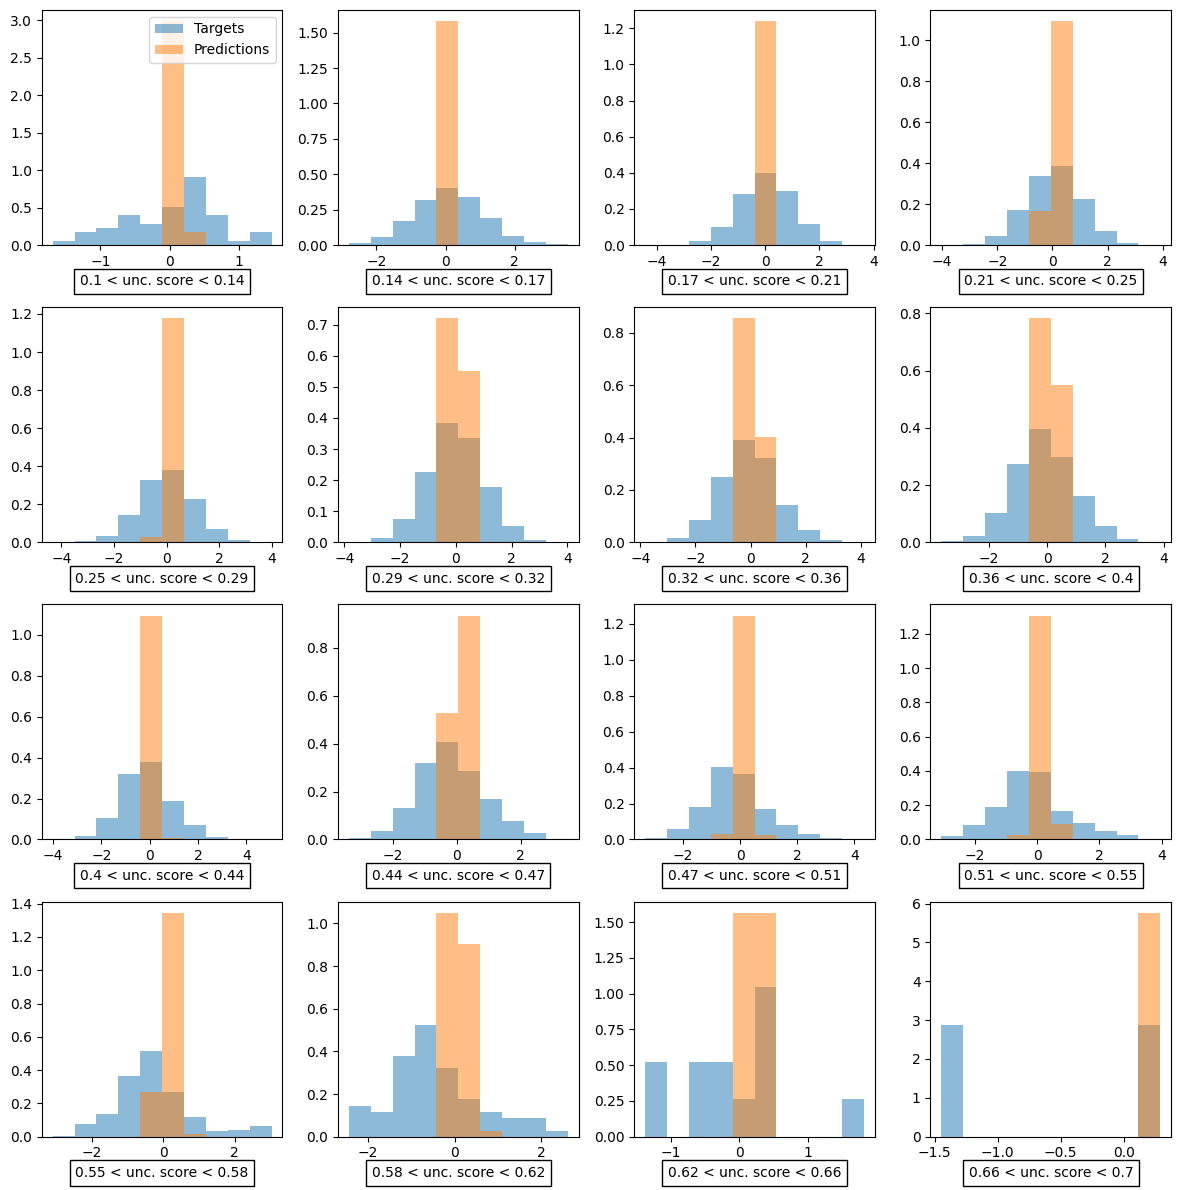

In [64]:
from scipy.stats import entropy

n_bins = 16

electron_targets = targets[:, 0]
electron_predictions = predictions[:, 0]

uncertainty_scores = 1 - mean_likelihoods

bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
bin_indices = np.digitize(uncertainty_scores, bin_edges)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

rounded_bin_edges = np.round(bin_edges, 2)

for i, ax in zip(range(n_bins), axes.flatten()):
  indices = bin_indices == i + 1
  hist_range = electron_targets[indices].min(), electron_targets[indices].max()

  targets_hist = ax.hist(electron_targets[indices], 10, hist_range, True, alpha=.5, label='Targets')[0]
  predictions_hist = ax.hist(electron_predictions[indices], 10, hist_range, True, alpha=.5, label='Predictions')[0]
  ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

  print('KL div:', entropy(predictions_hist, targets_hist))
axes[0, 0].legend()
plt.tight_layout()
plt.show()

# Band testing

In [65]:
mcd_train_uncertainty = np.load(dir + 'mcd_train_uncertainty.npy')
mcd_test_uncertainty = np.load(dir + 'mcd_test_uncertainty.npy')

mcd_train_uncertainty.shape, mcd_test_uncertainty.shape

((100000, 5), (100000, 5))

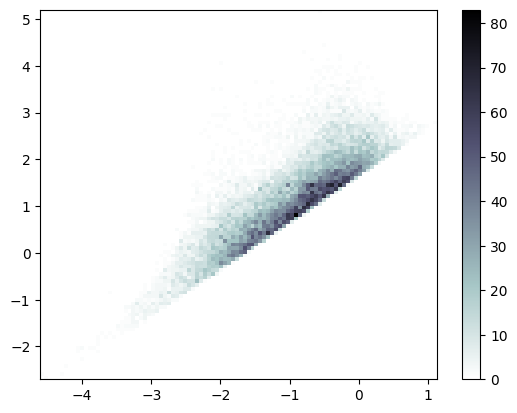

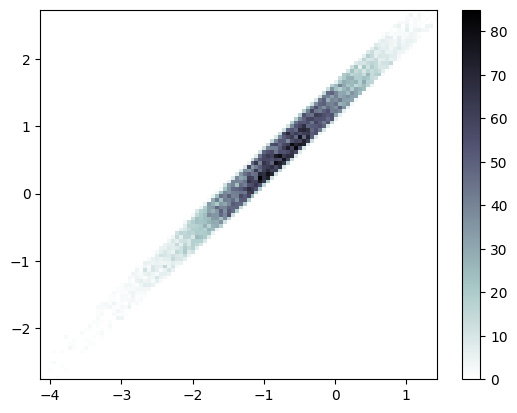

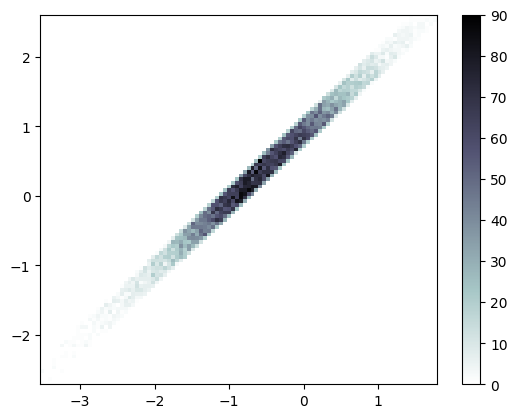

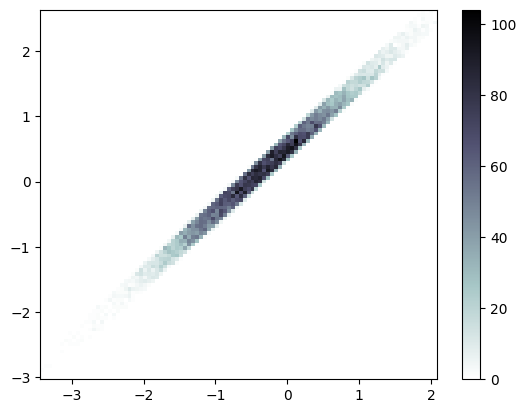

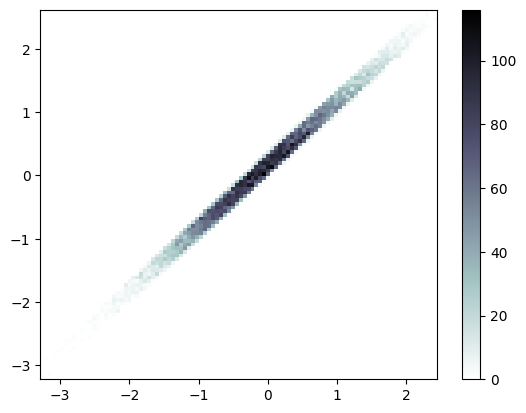

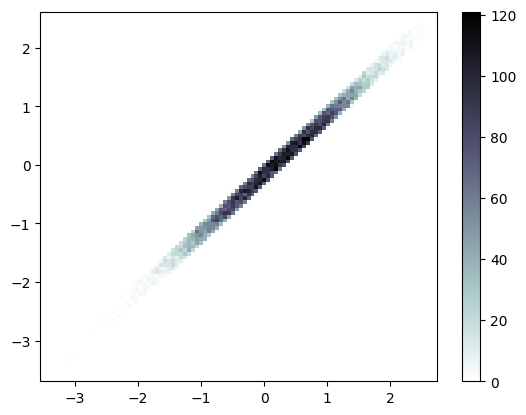

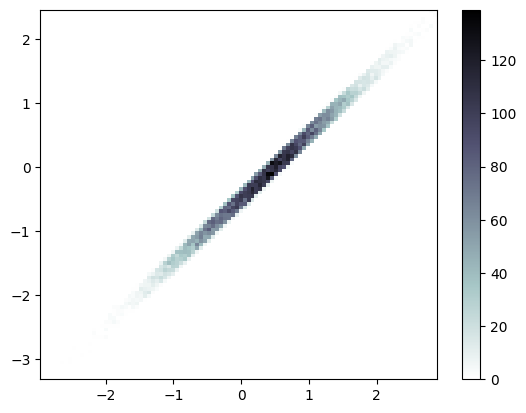

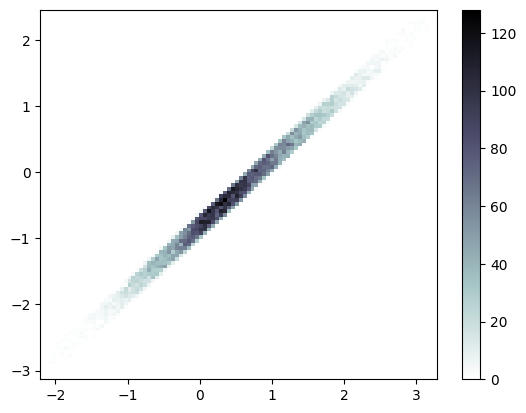

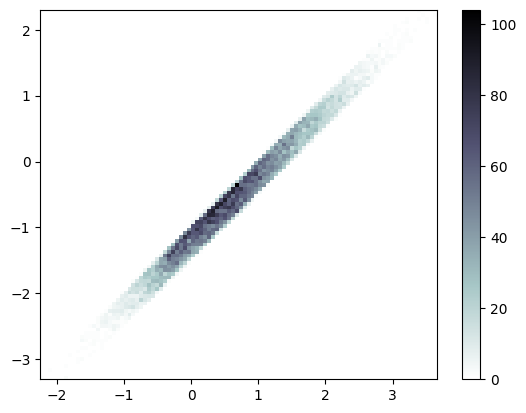

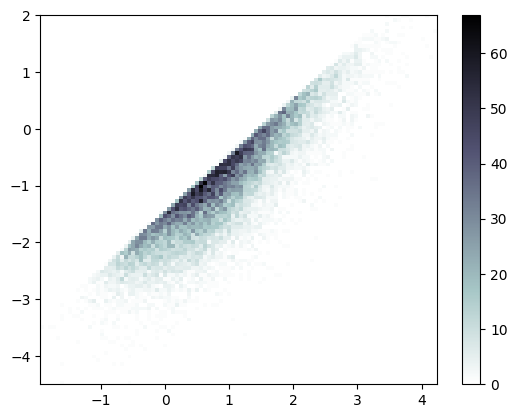

In [74]:
def split_by_bands(feats, targets, fd_likelihoods, mcd_likelihoods, band_size):
    distances = np.abs(feats[:, 0] - feats[:, 1])
    sort_indices = np.argsort(distances)

    feats_sorted = feats[sort_indices]
    targets_sorted = targets[sort_indices]
    fd_likelihoods_sorted = fd_likelihoods[sort_indices]
    mcd_likelihoods_sorted = mcd_likelihoods[sort_indices]

    num_bands = (feats.shape[0] - 1) // band_size + 1

    bands = []
    for i in range(num_bands):
        start = i * band_size
        end = start + band_size

        band = (feats_sorted[start:end], targets_sorted[start:end], fd_likelihoods_sorted[start:end], mcd_likelihoods_sorted[start:end])
        bands.append(band)

    return bands

n_samples = 100000

train_bands = split_by_bands(train_feats[:n_samples], train_targets[:n_samples], mean_train_likelihoods, mcd_train_uncertainty, band_size=20000)
test_bands = split_by_bands(test_feats[:n_samples], test_targets[:n_samples], mean_test_likelihoods, mcd_test_uncertainty, band_size=20000)
train_bands = train_bands[::-1]

bands = train_bands + test_bands

for band in bands:
    plt.hist2d(band[0][:, 0], band[0][:, 1], 100, cmap='bone_r')
    plt.colorbar()
    plt.show()

-0.8652575549120941


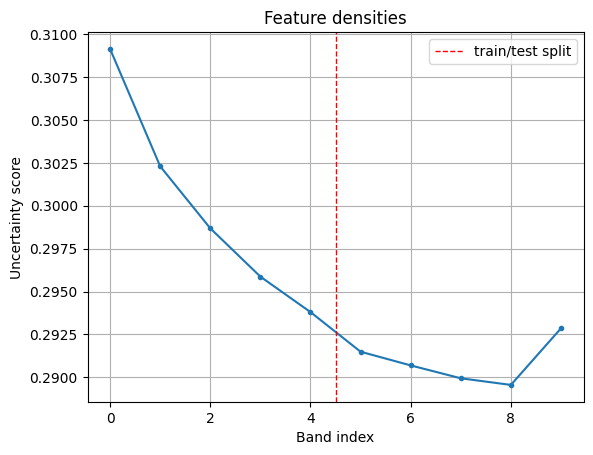

In [75]:
from scipy.stats import linregress

likelihood_means = []

for band in bands:
  likelihoods = band[2]
  likelihood_means += [1 - likelihoods.mean()]

x = range(len(bands))

print(linregress(x, likelihood_means).rvalue)

plt.title('Feature densities')
plt.gca().set_axisbelow(True)
plt.grid()
plt.plot(x, likelihood_means, '.-')
plt.axvline(len(train_bands) - .5, color='red', linestyle='--', linewidth=1, label='train/test split')
plt.xlabel('Band index')
plt.ylabel('Uncertainty score')
plt.legend()
plt.show()

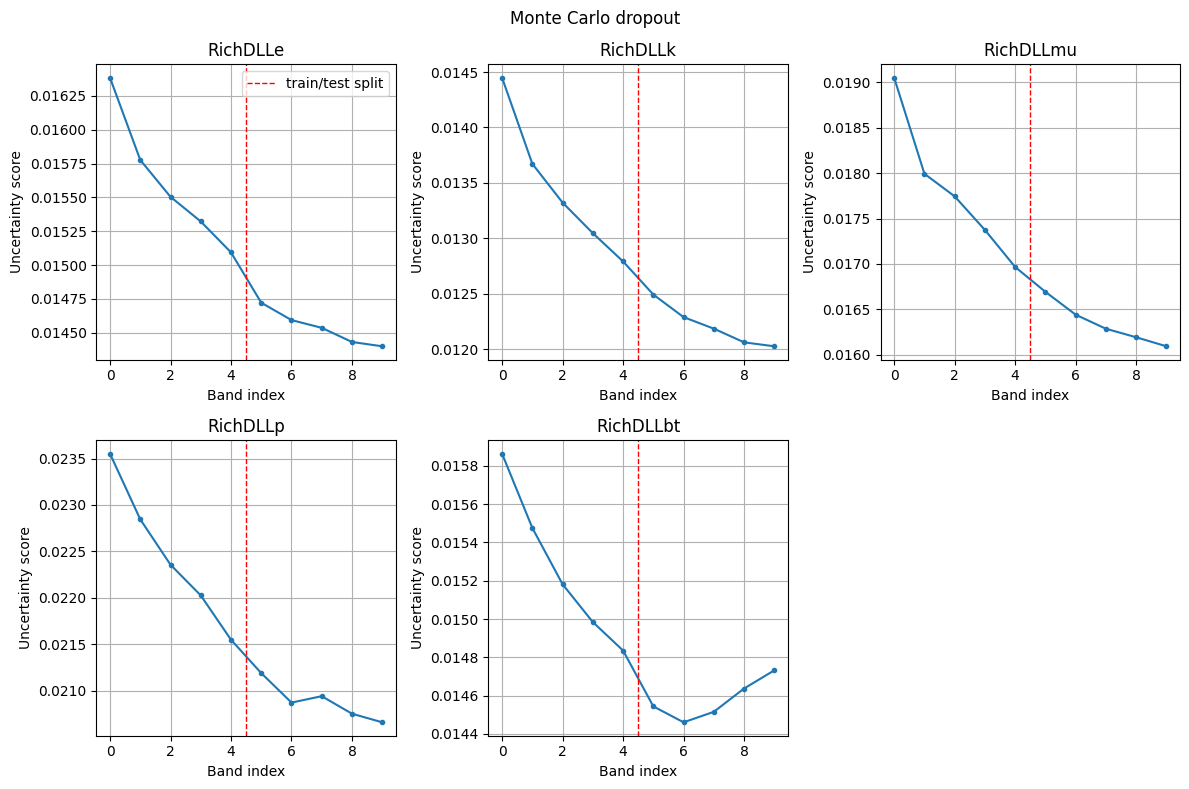

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in zip(range(5), axes.flatten()):
  band_likelihoods = []

  for band in bands:
    band_likelihoods += [band[3][:, i].mean()]

  ax.set_title(dll_columns[i])
  ax.set_axisbelow(True)
  ax.grid()
  ax.plot(x, band_likelihoods, '.-')
  ax.axvline(len(train_bands) - .5, color='red', linestyle='--', linewidth=1, label='train/test split')
  ax.set_xlabel('Band index')
  ax.set_ylabel('Uncertainty score')

plt.suptitle('Monte Carlo dropout')
axes[0, 0].legend()
axes[-1, -1].axis(False)
plt.tight_layout()
plt.show()

# Pion distributions

RichDLLe:
KL div: 1.22248444225177
JS dist: 0.579135085525711
Inv. hist. intersect: 0.6989100179169712

RichDLLk:
KL div: 1.4739415637524687
JS dist: 0.6014491240194321
Inv. hist. intersect: 0.7172249994058832

RichDLLmu:
KL div: 1.2256762280918283
JS dist: 0.5778128439169028
Inv. hist. intersect: 0.7053599925964682

RichDLLp:
KL div: 1.2676226347836683
JS dist: 0.5776375193400707
Inv. hist. intersect: 0.7096600056086777

RichDLLbt:
KL div: 1.409526293425589
JS dist: 0.5909183965245525
Inv. hist. intersect: 0.6888200034254774



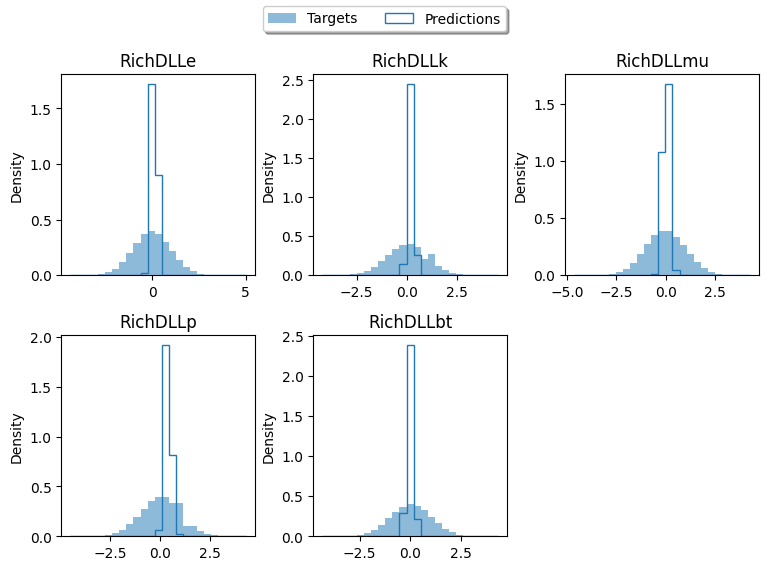

In [ ]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def hist_intersect(p, q):
  return np.minimum(p, q).sum() / q.sum()

n_bins = 25

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
plt.subplots_adjust(wspace=.3, hspace=.3)

for i, ax in zip(range(5), axes.flatten()):
  ax.set_title(dll_columns[i])

  hist_range = targets[:, i].min(), targets[:, i].max()

  targets_hist = ax.hist(targets[:, i], n_bins, hist_range, True, alpha=.5, label='Targets')[0]
  predictions_bins = ax.hist(predictions[:, i], n_bins, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]
  ax.set_ylabel('Density')

  print(f'{dll_columns[i]}:')
  print(f'KL div:', entropy(predictions_bins, targets_hist))
  print(f'JS dist:', jensenshannon(predictions_bins, targets_hist))
  print(f'Inv. hist. intersect:', 1 - hist_intersect(predictions_bins, targets_hist))
  print()

axes[-1, -1].axis(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=3)
plt.show()